
 # WatsonX Basic Multi-agent Collaboration

 A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools.

 One way to approach complicated tasks is through a "divide-and-conquer" approach: create an specialized agent for each task or domain and route tasks to the correct "expert".

 This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.) shows one way to do this using LangGraph.



The resulting graph will look something like the following diagram:

![multi_agent diagram](./img/simple_multi_agent_diagram.png)

Before we get started, a quick note: this and other multi-agent notebooks are designed to show _how_ you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

In [3]:
import logging
from typing import Any, Dict, List, Optional, Sequence, Type, Union, Callable, Literal
from pydantic import BaseModel, Field
from langchain_core.tools import BaseTool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import Runnable
from langchain_ibm import WatsonxLLM as BaseWatsonxLLM
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.outputs import LLMResult, Generation, GenerationChunk
from langchain_core.messages import BaseMessage
from langchain_core.language_models import LanguageModelInput
from dotenv import load_dotenv
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
import os
import getpass

logger = logging.getLogger(__name__)

# Simplified loading of environment variables and IBM connection parameters
load_dotenv()

def set_env(var: str):
    env_var = os.getenv(var)
    if not env_var:
        env_var = getpass.getpass(f"{var}: ")
        os.environ[var] = env_var
    return env_var

class IbmConnectionParams(BaseModel):
    api_key: str
    project_id: str
    url: str
    credentials: dict[str, str]

    def __init__(self, api_key: str, project_id: str, url: str) -> None:
        super().__init__(api_key=api_key, project_id=project_id, url=url, credentials={"url": url, "apikey": api_key})

# Set IBM connection parameters
ibm_params = IbmConnectionParams(
    api_key=set_env("WATSONX_API_KEY"),
    project_id=set_env("PROJECT_ID"),
    url = set_env("WATSONX_URL")
)

parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 1000,
    GenParams.MIN_NEW_TOKENS: 50,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}

class WatsonxLLM(BaseWatsonxLLM):
    """Extended IBM watsonx.ai large language models."""
    # Define the default parameters as class variables
    DEFAULT_MODEL_ID = "ibm/granite-13b-instruct-v2"
    DEFAULT_URL = ibm_params.url
    DEFAULT_APIKEY = ibm_params.api_key
    DEFAULT_PROJECT_ID = ibm_params.project_id
    DEFAULT_PARAMS = parameters    
    bound_tools: Optional[List[BaseTool]] = Field(default=None, exclude=True)

    def __init__(self, *args, tools: Optional[List[BaseTool]] = None, model_id: Optional[str] = None, **kwargs):
        if not model_id and 'deployment_id' not in kwargs:
            raise ValueError("One of 'model_id' or 'deployment_id' parameters should be set.")
        super().__init__(model_id=model_id, *args, **kwargs)
        self.bound_tools = tools or []

    def _generate(
        self,
        prompts: List[str],
        stop: Optional[List[str]] = None,
        run_manager: Optional[Any] = None,
        stream: Optional[bool] = None,
        **kwargs: Any,
    ) -> LLMResult:
        params = self._get_chat_params(stop=stop)
        should_stream = stream if stream is not None else self.streaming
        if should_stream:
            if len(prompts) > 1:
                raise ValueError(f"WatsonxLLM currently only supports single prompt, got {prompts}")
            generation = GenerationChunk(text="")
            stream_iter = self._stream(prompts[0], stop=stop, run_manager=run_manager, **kwargs)
            for chunk in stream_iter:
                if generation is None:
                    generation = chunk
                else:
                    generation += chunk
            assert generation is not None
            if isinstance(generation.generation_info, dict):
                llm_output = generation.generation_info.pop("llm_output")
                return LLMResult(generations=[[generation]], llm_output=llm_output)
            return LLMResult(generations=[[generation]])
        else:
            print("Step 1 - Starting Tool Evaluation")
                        
            if self.bound_tools:
                print("Step 1.1 self.bound_tools")
                print("type(self.bound_tools)", type(self.bound_tools)) 
                print("self.bound_tools", self.bound_tools)
                
                tool_output = self._evaluate_tools(self.bound_tools, prompts[0])
                logger.info("Tool output: %s", tool_output)

                system_prompt = (
                    f"You are an assistant with access to web search results. "
                    f"Provide a detailed answer to the user's query.\n\n"
                    f"User Query: {prompts[0]}\n\n"
                    f"Using the information below:\n"
                    f"Web Search Results: {tool_output}\n\n"
                )
                prompts[0] = system_prompt

            print("prompts", prompts)

            if not isinstance(params, dict):
                raise ValueError(f"Expected params to be a dictionary, got {type(params)}")

            response = self.watsonx_model.generate(prompt=prompts, params=params, **kwargs)
            return self._create_llm_result(response)


    def _evaluate_tools(self, tool_instances: List[BaseTool], input_text: str) -> str:
        combined_output = []
        print(f"Debug: Starting tool evaluation for input: {input_text}")
        print("tool_instances:", tool_instances)

        for tool in tool_instances:
            try:
                # Invoke the tool with the provided input
                result = tool.invoke(input_text)
                print(f"Debug: Result from tool {tool.name}: {result}")

                # Check the type of result and handle it accordingly
                if isinstance(result, str):
                    content = f"WebSearch Results: {result}"
                elif isinstance(result, list) and all(isinstance(item, dict) for item in result):
                    content = "WebSearch Results: " + " ".join(item.get('content', '') for item in result)
                elif isinstance(result, dict):
                    content = "WebSearch Results: " + result.get('content', 'Unknown response format')
                else:
                    content = "WebSearch Results: Invalid format received from tool"

                # Append the processed content to the combined output
                combined_output.append(content)

            except Exception as e:
                error_message = f"Error invoking tool {tool.name}: {str(e)}"
                print(f"Debug: {error_message}")
                combined_output.append(error_message)

        final_output = "\n\n".join(combined_output)
        print(f"Debug: Final combined output: {final_output}")
        return final_output

    @classmethod
    def bind_tools(
        cls,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        model_id: Optional[str] = None,
        url: Optional[str] = None,
        apikey: Optional[str] = None,
        project_id: Optional[str] = None,
        params: Optional[Dict[str, Any]] = None,
        tool_choice: Optional[Union[Dict[str, str], Literal["any", "auto"], str]] = None,
        **kwargs: Any,
    ) -> 'WatsonxLLM':
        formatted_tools = [convert_to_openai_tool(tool)["function"] for tool in tools]
        # Initialize WatsonxLLM with the provided parameters
        instance = cls(
            model_id=model_id,
            url=url,
            apikey=apikey,
            project_id=project_id,
            params=params,
            **kwargs
        )
        instance.bound_tools = tools
        if tool_choice is not None:
            kwargs["tool_choice"] = tool_choice
        return instance

    def _create_llm_result(self, response: List[dict]) -> LLMResult:
        generations = []
        for res in response:
            results = res.get("results")
            if results:
                finish_reason = results[0].get("stop_reason")
                gen = Generation(
                    text=results[0].get("generated_text"),
                    generation_info={"finish_reason": finish_reason},
                )
                generations.append([gen])
        final_token_usage = self._extract_token_usage(response)
        llm_output = {
            "token_usage": final_token_usage,
            "model_id": self.model_id,
            "deployment_id": self.deployment_id,
        }
        return LLMResult(generations=generations, llm_output=llm_output)

# Example usage:
tool = TavilySearchResults(max_results=4)

# Bind the tool and pass all necessary parameters inside `bind_tools`
llm_with_tools = WatsonxLLM.bind_tools(
    tools=[tool],
    model_id="ibm/granite-13b-instruct-v2",
    url=ibm_params.url,
    apikey=ibm_params.api_key,
    project_id=ibm_params.project_id,
    params=parameters
)
# Invoke the model
#response = llm_with_tools.invoke("Who is Ruslan Magana?")
#print(response)


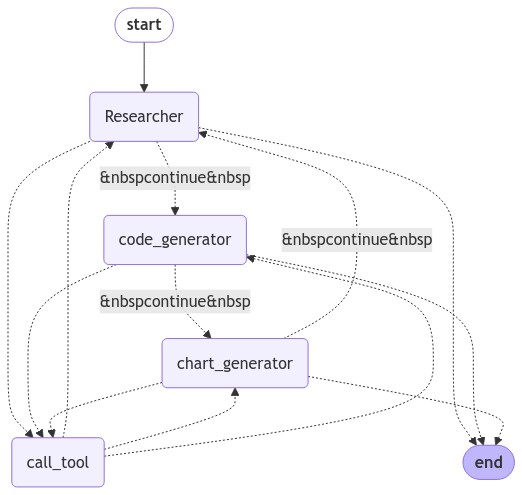

In [4]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
import functools
import re
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
import operator
from typing import Annotated, Sequence, TypedDict

# Define the object passed between nodes
class AgentState(TypedDict):
    messages: Annotated[Sequence[AIMessage], operator.add]
    sender: str

# Tool Initialization
tavily_tool = TavilySearchResults(max_results=4)
repl = PythonREPL()

# Define Python REPL Tool
@tool
def python_repl(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code. If you want to see the output of a value, you should print it out with `print(...)`. This is visible to the user."""
    try:
        exec(code)
        result = ""
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."

# Function to handle research data (Researcher Agent Node)
def agent_node(state, agent, name):
    result = agent.invoke(state)
    print(f"Debug: Agent {name} invoked with state: {state}")
    print(f"Debug: Result from agent {name}: {result}")

    # If the agent is the researcher, print the research data
    if name == "Researcher":
        if isinstance(result, str) and "Error" in result:
            print("Debug: Error occurred in Research Agent. Retrying...")
        else:
            # Print the full result directly as research data
            print(f"Debug: Extracted Research Data: {result}")

    # Filter Python code if invoking the chart generator
    if name == "chart_generator" or name == "code_generator":
        result = filter_python_code(result)

    # Handle different result types
    if hasattr(result, 'dict'):
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    else:
        result = AIMessage(content=str(result), name=name)

    return {
        "messages": [result],
        "sender": name,
    }

# Simplified agent creation function
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a helpful AI assistant, collaborating with other assistants. "
             "Use the provided tools to answer the question. If you can't answer fully, another assistant will help. "
             "Prefix final responses with FINAL ANSWER.\nTools available: {tool_names}.\n{system_message}"),
            MessagesPlaceholder(variable_name="messages"),
        ]
    ).partial(system_message=system_message, tool_names=", ".join([tool.name for tool in tools]))

    return prompt | llm.bind_tools(
        tools=tools,
        model_id="ibm/granite-13b-instruct-v2",
        url=ibm_params.url,
        apikey=ibm_params.api_key,
        project_id=ibm_params.project_id,
        params=parameters
    )

# Extract Python code from the result
def filter_python_code(result):
    """
    Extract all valid Python code blocks from the AI-generated response.
    Looks for code blocks enclosed within triple backticks (```python ... ```).
    Returns a list of code blocks, or a message if none are found.
    """
    code_blocks = re.findall(r"```python\s*(.*?)```", str(result), re.DOTALL)
    if code_blocks:
        return [code.strip() for code in code_blocks]
    else:
        return "No Python code blocks found."

# Function to invoke agents and handle their results
def agent_node(state, agent, name):
    result = agent.invoke(state)
    print(f"Debug: Agent {name} invoked with state: {state}")
    print(f"Debug: Result from agent {name}: {result}")

    # If the agent is the researcher, extract research data
    if name == "Researcher":
        if isinstance(result, str) and "Error" in result:
            print("Debug: Error occurred in Research Agent. Retrying...")
        else:
            # Print the result directly
            print(f"Debug: Extracted Research Data: {result}")

    # Filter Python code if invoking the chart generator
    if name == "chart_generator" or name == "code_generator":
        result = filter_python_code(result)

    # Handle different result types
    if hasattr(result, 'dict'):
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    else:
        result = AIMessage(content=str(result), name=name)

    return {
        "messages": [result],
        "sender": name,
    }

# Define agents and their nodes
research_agent = create_agent(
    WatsonxLLM, [tavily_tool], system_message="Provide accurate data for the chart generator."
)
chart_agent = create_agent(
    WatsonxLLM, [python_repl], system_message="Any charts you display will be visible to the user."
)

# Python Code Generator Agent (new)
code_generator_agent = create_agent(
    WatsonxLLM, [], system_message="Generate Python code using matplotlib for drawing the chart based on the researcher's data."
)

research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")
code_generator_node = functools.partial(agent_node, agent=code_generator_agent, name="code_generator")

# Create tool node
tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

# Define router for graph transitions
def router(state) -> str:
    last_message = state["messages"][-1]
    print(f"Debug: Last message in state: {last_message}")
    
    if last_message.tool_calls:
        print("Debug: Routing to call_tool")
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        print("Debug: Routing to __end__")
        return "__end__"
    print("Debug: Continuing to next node")
    return "continue"

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("code_generator", code_generator_node)
workflow.add_node("call_tool", tool_node)
workflow.add_conditional_edges("Researcher", router, {"continue": "code_generator", "call_tool": "call_tool", "__end__": END})
workflow.add_conditional_edges("code_generator", router, {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END})
workflow.add_conditional_edges("chart_generator", router, {"continue": "Researcher", "call_tool": "call_tool", "__end__": END})
workflow.add_conditional_edges("call_tool", lambda x: x["sender"], {"Researcher": "Researcher", "chart_generator": "chart_generator", "code_generator": "code_generator"})

# Set the entry point of the workflow
workflow.set_entry_point("Researcher")

# Compile the workflow for execution
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass


In [ ]:
# Execute the graph stream with a test message
events = graph.stream(
    {
        "messages": [
            HumanMessage(content="Fetch the bitcoin price over the past 5 days, then draw a line graph of it.")
        ]
    },
    {"recursion_limit": 50}
)

# Output the results
for s in events:
    print(s)
    print("----")
